## Support Vector Machines:
Objective :
1. You need to work with 2 versions of SVM
a. Linear kernel
b. RBF kernel
2. When you are working with linear kernel, if want a computationally less expensive
algorithm you can go with ‘SGDClassifier’ with hinge loss.
3. When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
score, you might need to use CalibratedClassifierCV
4. Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions.
5. When you are working on the linear kernel with BOW or TFIDF please print the best
feature for each of the positive and negative classes.
6. Try to introduce some features, and work more on featurizations so that your model can
do better.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as npz
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
#taking cleaned data i.e in Reviews table  from final sql database
#making connection with database 
conn = sqlite3.connect('final.sqlite') 
final = pd.read_sql_query(""" SELECT * FROM Reviews ORDER BY Time""", conn) 


C:\Users\nisha\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
final = final[:25000]
print(len(final))

25000


In [3]:
CleanedText = final['CleanedText'];
text=final.CleanedText.values
#print(CleanedText)
CleanedText_Class = [];
for i in final['Score']:
    if (i == 'positive'):
        CleanedText_Class.append(1)
    else:
        CleanedText_Class.append(0)
    

### Spliting the original data into Train,CV and Test

In [4]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
# ====================================
# split the data set into train and test for BoW
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
X_1, X_test, y_1, y_test = cross_validation.train_test_split(text, CleanedText_Class, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import svm, grid_search

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from tqdm import tqdm
import os

from wordcloud import WordCloud
import seaborn as sns; 

def most_informative_feature_for_binary_classification(vectorizer, w,n_features,is_print = True):
#     class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(w, feature_names), reverse=False)[:n_features]
    topn_class2 = sorted(zip(w, feature_names), reverse=True)[:n_features]
#     print(feature_names)
    if is_print == True:
        print("\nTop %s negative features"% (n_features))
        for w, feat in topn_class1:
            print( w, feat)
        
        print("\nTop %s positive features" %(n_features))
#         for w, feat in reversed(topn_class2):
        for w, feat in topn_class2:
            print(w, feat)
        
    else:
        top_features_dict ={};
        top_negative_features_name_list =[]
        top_positive_features_name_list =[]
        for coef, feat in topn_class1:
            top_negative_features_name_list.append(feat)
            
#         for coef, feat in reversed(topn_class2):
        for coef, feat in topn_class2:
            top_positive_features_name_list.append(feat)
            
        top_features_dict ={"top_negative_features_name_list":top_negative_features_name_list,"top_positive_features_name_list":top_positive_features_name_list}
        return top_features_dict;


def top_features_wordcloud_generated_image_fun(features_list):
    wordcloud = WordCloud(width=600, height=600, margin=0,background_color="white").generate(" ".join(features_list))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()


### Bow
Applying Bow vectorizer on data

In [6]:
#BOW 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vocabulary= vectorizer.fit(X_tr)
#print("the shape of out text BOW vectorizer ",vocabulary.get_shape())
#bow_x_tr.shape
# bow_tr_array

In [7]:
bow_x_tr= vectorizer.transform(X_tr)
print("the shape of out text BOW vectorizer ",bow_x_tr.get_shape())

the shape of out text BOW vectorizer  (12250, 14598)


In [8]:
bow_x_cv= vectorizer.transform(X_cv)
print("the shape of out text BOW vectorizer ",bow_x_cv.get_shape())

the shape of out text BOW vectorizer  (5250, 14598)


#### Doing col-std on Bow train and CV

In [9]:
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(bow_x_tr)
# print(scaler.fit(bow_x_tr))
# print(scaler.mean_)
Standardize_bow_x_tr= scaler.transform(bow_x_tr)
# print(Standardize_bow_x_tr)
# print(scaler.mean_)
Standardize_bow_x_cv= scaler.transform(bow_x_cv)
# print(Standardize_bow_x_cv)
# print(scaler.mean_)

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Apply GridSearchCV 

#### 1. SVM RBF

In [10]:
Cs = [0.0001, 0.01, 0.1, 1,10,100]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='rbf',class_weight='balanced'), param_grid, cv=3)
grid_search.fit(Standardize_bow_x_tr, y_tr)

print(grid_search.best_estimator_)
# print(grid_search.score(Standardize_bow_x_cv, y_cv))

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8878095238095238


In [26]:
# grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_
df_gridsearch = pd.DataFrame(grid_search.cv_results_)
# df_gridsearch.head()
grid_search.best_params_,grid_search.best_score_

({'C': 1, 'gamma': 0.001}, 0.8946938775510204)

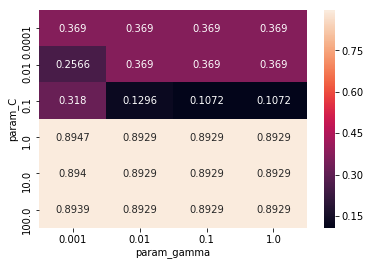

In [24]:
max_scores = df_gridsearch.groupby(['param_C', 
                                    'param_gamma']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [12]:
Bow_optimal_c = 1
Bow_optimal_gamma = 0.001

### 2. SGDClassifier
a. Using SGDClassifier with hinge loss because it is computationally less expensive than linear kernel

b. when we are using SGD with hinge loss, we won't be having predict_proba, and without probability scores we can't compute the ROC_AUC scores, so we would have to use CalibratedClassifierCV



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]


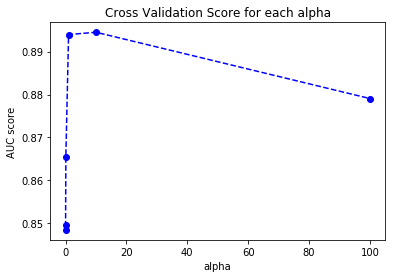

[0.0001, 0.01, 0.1, 1, 10, 100]
[0.8495141152978751, 0.8484839456860123, 0.8654228774467876, 0.8939574988630445, 0.8945020170864578, 0.8790702916672201]


In [41]:
alpha = [0.0001, 0.01, 0.1, 1,10,100]

auc_results=[]
for i in tqdm(alpha):
    
    clf = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    clf.fit(Standardize_bow_x_tr, y_tr)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(Standardize_bow_x_tr, y_tr)
    predict_y = sig_clf.predict_proba(Standardize_bow_x_cv)
    preds = predict_y[:,1]
#     print(predict_y)
    roc_auc = roc_auc_score(y_cv, preds)
    auc_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
plt.plot(alpha, auc_results, 'b--o', label='AUC Score')
plt.title("Cross Validation Score for each alpha")
plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()
print(alpha)
print(auc_results)

In [46]:
Bow_optimal_alpha = 10
clf = linear_model.SGDClassifier(alpha=Bow_optimal_alpha,class_weight='balanced')
clf = clf.fit(Standardize_bow_x_tr, y_tr)
w = clf.coef_ 

## Important Features of both the classes

In [47]:
most_informative_feature_for_binary_classification(vectorizer,w[0],10,True)


Top 10 negative features
-0.021340236070304722 disappoint
-0.016938105916467175 worst
-0.014958047457462823 horribl
-0.014840420162349266 return
-0.01399953406745429 aw
-0.013629205095649464 bad
-0.013450380774066939 threw
-0.013181262683644564 terribl
-0.012941969038439386 money
-0.012529674668454213 wast

Top 10 positive features
0.01983908398851444 great
0.016426334041686665 love
0.01429542932999421 best
0.012198296830406356 delici
0.011561673912708091 favorit
0.010940717327205017 perfect
0.00988985211825448 wonder
0.009441187419154855 find
0.008894166887949124 nice
0.008514294961175497 excel


### Top Negative Features 

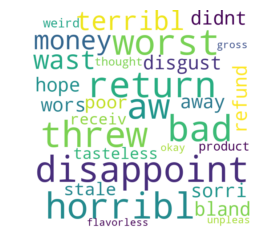

In [48]:
top_features = most_informative_feature_for_binary_classification(vectorizer,w[0],30,False)
top_features_wordcloud_generated_image_fun(top_features["top_negative_features_name_list"])

### Top Positive Features 

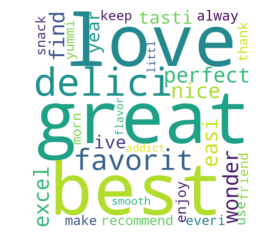

In [49]:
top_features_wordcloud_generated_image_fun(top_features["top_positive_features_name_list"])

### Performance measure of Test Data on Trained Model with different performance metrix

In [10]:
# vectorizing the test data into Bow for model implementation 
bow_x_test= vectorizer.transform(X_test)
print("the shape of out text BOW vectorizer ",bow_x_test.get_shape())

Standardize_bow_x_test= scaler.transform(bow_x_test)
# print(Standardize_bow_x_test)
# print(scaler.mean_)

the shape of out text BOW vectorizer  (7500, 14598)


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### 1. SVC RBF Performance 

In [14]:
#apply SVC RBF Kernel with optimal c and gamma on test data 
clf = SVC(C = Bow_optimal_c,gamma=Bow_optimal_gamma,kernel='rbf',class_weight='balanced')
clf.fit(Standardize_bow_x_tr, y_tr) 
# predict the response
pred = clf.predict(Standardize_bow_x_test)

####SVC RBF KERNEL SCORE####

The weighted f1_score  with C =1.000000 and Gamma = 0.001000  is 85.355114%

The f1_score with C =1.000000 and Gamma = 0.001000  is 94.338282%

The recall_score with C =1.000000 and Gamma = 0.001000  is 99.624906%

The precision_score with C =1.000000 and Gamma = 0.001000  is 89.584458%

The confusion_matrix with C =1.000000 and Gamma = 0.001000 
[[  63  772]
 [  25 6640]]


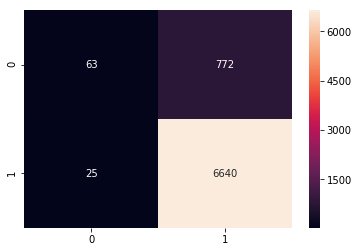

In [15]:
optimal_C = Bow_optimal_c
optimal_gamma = Bow_optimal_gamma
# evaluate weighted f1_score
print("####SVC RBF KERNEL SCORE####")
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score  with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix with C =%f and Gamma = %f ' % (optimal_C,optimal_gamma))
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [16]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix for C = %f and Gamma = %f " %(optimal_C,optimal_gamma))

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for BOW *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix for C = 1.000000 and Gamma = 0.001000 

******* for BOW *********

****TPR is 99%

****FPR is 92%

****FNR is 0%

****TNR is 7%


#### 2. SGDClassifier Performance 

In [64]:
clf = linear_model.SGDClassifier(alpha=Bow_optimal_alpha,class_weight='balanced')
clf = clf.fit(Standardize_bow_x_tr, y_tr)
pred = clf.predict(Standardize_bow_x_test)

#### SGDClassifier SCORE ####

The weighted f1_score  with C =1.000000 and Gamma = 0.001000  is 87.636856%

The f1_score with C =1.000000 and Gamma = 0.001000  is 91.755990%

The recall_score with C =1.000000 and Gamma = 0.001000  is 87.336834%

The precision_score with C =1.000000 and Gamma = 0.001000  is 96.646190%

The confusion_matrix with C =1.000000 and Gamma = 0.001000 
[[ 633  202]
 [ 844 5821]]


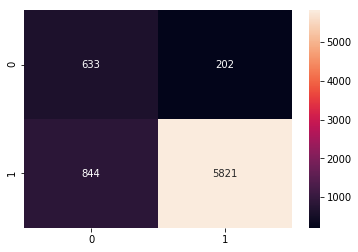

In [66]:
# evaluate weighted f1_score
print("#### SGDClassifier SCORE  with alpha =%f####"% (Bow_optimal_alpha))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score  is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score  is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix ')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [67]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix")

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for BOW *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix for C = 1.000000 and Gamma = 0.001000 

******* for BOW *********

****TPR is 87%

****FPR is 24%

****FNR is 12%

****TNR is 75%


*********Bow Ends***

## TF-IDF

In [17]:
#tfidf 
tf_idf_vect = TfidfVectorizer()
vocabulary = tf_idf_vect.fit(X_tr)
#print("the shape of out text TF-IDF vectorizer ",tf_idf_x_tr.get_shape())

In [18]:
tf_idf_x_tr = tf_idf_vect.transform(X_tr)
print("the shape of out text TF-IDF vectorizer ",tf_idf_x_tr.get_shape())

the shape of out text TF-IDF vectorizer  (12250, 14598)


In [19]:
tf_idf_x_cv = tf_idf_vect.transform(X_cv)
print("the shape of out text TF-IDF vectorizer ",tf_idf_x_cv.get_shape())

the shape of out text TF-IDF vectorizer  (5250, 14598)


### col-std on TF-IDF train and CV

In [20]:
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(tf_idf_x_tr)
# print(scaler.fit(tf_idf_x_tr))
# print(scaler.mean_)
Standardize_tf_idf_x_tr= scaler.transform(tf_idf_x_tr)
# print(Standardize_tf_idf_x_tr)
# print(scaler.mean_)
Standardize_tf_idf_x_cv= scaler.transform(tf_idf_x_cv)
# print(Standardize_tf_idf_x_cv)
# print(scaler.mean_)

### Apply GridSearch on TF-IDF

#### 1.  SVC RBF KERNEL

In [14]:
Cs = [0.0001, 0.01, 0.1, 1,10,100,100]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=3)
grid_search.fit(Standardize_tf_idf_x_tr, y_tr)

print(grid_search.best_estimator_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [15]:
# grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_
df_gridsearch = pd.DataFrame(grid_search.cv_results_)
# df_gridsearch.head()
grid_search.best_params_,grid_search.best_score_

({'C': 1, 'gamma': 0.001}, 0.8861224489795918)

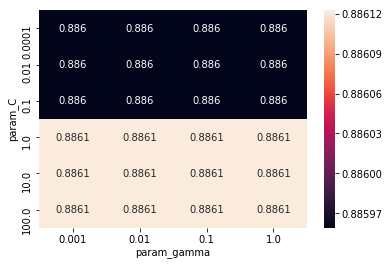

In [16]:
max_scores = df_gridsearch.groupby(['param_C', 
                                    'param_gamma']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [21]:
tfidf_optimal_c = 1
tfidf_optimal_gamma = 0.001

### 2. SGDClassifier

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.48it/s]


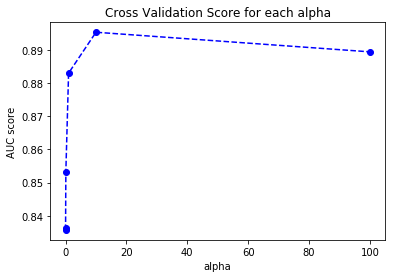

[0.0001, 0.01, 0.1, 1, 10, 100]
[0.835773734551494, 0.8363724533363677, 0.8532579024239137, 0.8829572974953956, 0.8952597481145563, 0.889361937350612]


In [72]:
alpha = [0.0001, 0.01, 0.1, 1,10,100]

auc_results=[]
for i in tqdm(alpha):
    
    clf = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    clf.fit(Standardize_tf_idf_x_tr, y_tr)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(Standardize_tf_idf_x_tr, y_tr)
    predict_y = sig_clf.predict_proba(Standardize_tf_idf_x_cv)
    preds = predict_y[:,1]
#     print(predict_y)
    roc_auc = roc_auc_score(y_cv, preds)
    auc_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
plt.plot(alpha, auc_results, 'b--o', label='AUC Score')
plt.title("Cross Validation Score for each alpha")
plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()
print(alpha)
print(auc_results)

### Getting Important Features for both the Classes - TF-IDF 
using LinearSVC

In [24]:
tfidf_optimal_alpha = 10
clf = linear_model.SGDClassifier(alpha=tfidf_optimal_alpha,class_weight='balanced')
clf = clf.fit(Standardize_tf_idf_x_tr, y_tr)
w = clf.coef_ 

In [75]:
most_informative_feature_for_binary_classification(tf_idf_vect,w[0],10,True)


Top 10 negative features
-0.02136033945064877 disappoint
-0.020034438894862453 worst
-0.01692806431864262 horribl
-0.016869121234390067 return
-0.015692081732757806 bad
-0.014583476220381548 aw
-0.013910156266805227 terribl
-0.013556483785380196 wast
-0.0134691603644482 disgust
-0.01271808795381919 threw

Top 10 positive features
0.020457108270352176 great
0.017168539802469008 love
0.015172830562805925 best
0.01277818390583379 delici
0.011734534777273467 favorit
0.011271608434653269 perfect
0.010357599877059833 find
0.00962585401061493 wonder
0.0092108710774796 nice
0.009003682605003834 use


### Top Negative Features

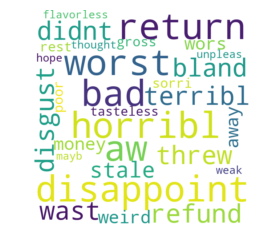

In [76]:
top_features = most_informative_feature_for_binary_classification(tf_idf_vect,w[0],30,False)
top_features_wordcloud_generated_image_fun(top_features["top_negative_features_name_list"])

### Top Positive Features

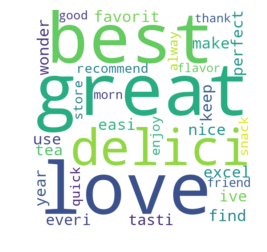

In [77]:
top_features_wordcloud_generated_image_fun(top_features["top_positive_features_name_list"])

### Performance measure of Test Data on Trained Model with different performance metrix - TF-IDF
#### 1. SVC RBF Performance

In [25]:
tf_idf_x_test= tf_idf_vect.transform(X_test)
print("the shape of out text TF-IDF vectorizer ",tf_idf_x_test.get_shape())

Standardize_tf_idf_x_test= scaler.transform(tf_idf_x_test)
# print(Standardize_tf_idf_x_test)
# print(scaler.mean_)

the shape of out text TF-IDF vectorizer  (7500, 14598)


In [31]:
#apply SVC RBF Kernel with optimal c and gamma on test data 
optimal_C = tfidf_optimal_c
optimal_gamma = tfidf_optimal_gamma
clf = SVC(C = optimal_C,gamma=optimal_gamma,kernel='rbf',class_weight='balanced')
clf.fit(Standardize_tf_idf_x_tr, y_tr) 
# predict the response
pred = clf.predict(Standardize_tf_idf_x_test)

####SVC RBF KERNEL SCORE####

The weighted f1_score  with C =1.000000 and Gamma = 0.001000  is 83.783412%

The f1_score with C =1.000000 and Gamma = 0.001000  is 94.130941%

The recall_score with C =1.000000 and Gamma = 0.001000  is 99.984996%

The precision_score with C =1.000000 and Gamma = 0.001000  is 88.924473%

The confusion_matrix with C =1.000000 and Gamma = 0.001000 
[[   5  830]
 [   1 6664]]


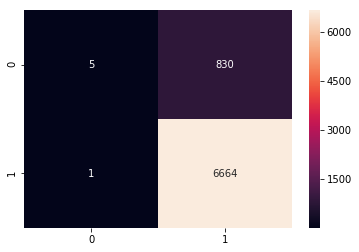

In [32]:
# evaluate weighted f1_score
print("####SVC RBF KERNEL SCORE####")
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score  with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix with C =%f and Gamma = %f ' % (optimal_C,optimal_gamma))
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [33]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix for C = %f and Gamma = %f " %(optimal_C,optimal_gamma))

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for TF-IDF *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix for C = 1.000000 and Gamma = 0.001000 

******* for TF-IDF *********

****TPR is 99%

****FPR is 99%

****FNR is 0%

****TNR is 0%


### 2. SGDClassifier Performance
using SGDClassifier because it is computationally less expensive Than Linear SVC.

In [74]:
clf = linear_model.SGDClassifier(alpha=tfidf_optimal_alpha,class_weight='balanced')
clf = clf.fit(Standardize_tf_idf_x_tr, y_tr)
pred = clf.predict(Standardize_tf_idf_x_test)

#### SGDClassifier SCORE  with alpha =10.000000####

The weighted f1_score is 86.596873%

The f1_score  is 90.839634%

The recall_score is 85.626407%

The precision_score  is 96.728814%

The confusion_matrix 
[[ 642  193]
 [ 958 5707]]


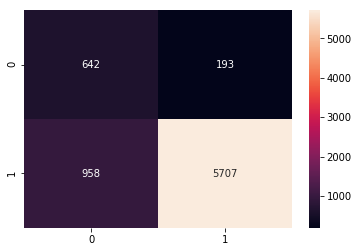

In [75]:
# evaluate weighted f1_score
print("#### SGDClassifier SCORE  with alpha =%f####"% (tfidf_optimal_alpha))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score  is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score  is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix ')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [76]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix")

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for TF-IDF *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix

******* for TF-IDF *********

****TPR is 85%

****FPR is 23%

****FNR is 14%

****TNR is 76%


*TF-IDF Ends***

## Word2Vec

In [34]:
#Word2Vec mode 
#spliting train sentence in words 
# Train your own Word2Vec model using your own text corpus
i=0
X_tr_list_of_sent=[]
for sent in X_tr:
    X_tr_list_of_sent.append(sent.split())
    
print(len(X_tr))
# print("\n--------------Spliting each sentence into words--------word list of ie data corpus---------\n")
# print(X_tr_list_of_sent[:2])
#word list of ie data corpus

12250


In [35]:
#The Word to Vec model produces a vocabulary, with each word being represented by 
#an n-dimensional numpy array 
X_tr_w2v_model=Word2Vec(X_tr_list_of_sent,min_count=1,size=50, workers=4)
X_tr_w2v_model.wv['man']
wlist =list(X_tr_w2v_model.wv.vocab)
# wlist is a list of words 
len(wlist)

14598

#### Train for Avgword2vec

In [36]:
#CALCULATE AVG WORD2VEC FOR x_tr
w2v_words = list(X_tr_w2v_model.wv.vocab)
# compute average word2vec for each review.
X_tr_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_tr_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_tr_sent_vectors.append(sent_vec)
print(len(X_tr_sent_vectors))
print(len(X_tr_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 12250/12250 [00:26<00:00, 460.26it/s]


12250
50


#### CV for Avgword2vec

In [37]:
#spliting cv sentence in words 
i=0
X_cv_list_of_sent=[]
for sent in X_cv:
    X_cv_list_of_sent.append(sent.split())
    
#word list of ie data corpus

In [38]:
#CALCULATE AVG WORD2VEC FOR x_cv 
# w2v_words = list(X_cv_w2v_model.wv.vocab)
w2v_words = list(X_tr_w2v_model.wv.vocab)

# compute average word2vec for each review in cv .
X_cv_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_cv_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
#             vec = X_cv_w2v_model.wv[word]
            vec = X_tr_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_sent_vectors.append(sent_vec)
print(len(X_cv_sent_vectors))
print(len(X_cv_sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5250/5250 [00:14<00:00, 373.12it/s]


5250
50


#### Avgword2vec on Test data

In [39]:
#Train your own Word2Vec model using your own text corpus
#spliting test sentence in words 
i=0
X_test_list_of_sent=[]
for sent in X_test:
    X_test_list_of_sent.append(sent.split())
    
print(len(X_test_list_of_sent))

7500


In [40]:
#CALCULATE AVG WORD2VEC FOR x_test
# w2v_words = list(X_test_w2v_model.wv.vocab)

w2v_words = list(X_tr_w2v_model.wv.vocab)

# compute average word2vec for each review.
X_test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
#             vec = X_test_w2v_model.wv[word]
            vec = X_tr_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_sent_vectors.append(sent_vec)
print(len(X_test_sent_vectors))
print(len(X_test_sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:18<00:00, 396.63it/s]


7500
50


### col-std on Avg word2vec train , CV and test

In [41]:
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(X_tr_sent_vectors)
# print(scaler.fit(X_tr_sent_vectors))
# print(scaler.mean_)
Standardize_X_tr_sent_vectors= scaler.transform(X_tr_sent_vectors)
# print(Standardize_X_tr_sent_vectors)
# print(scaler.mean_)
Standardize_X_cv_sent_vectors= scaler.transform(X_cv_sent_vectors)
# print(Standardize_X_cv_sent_vectors)
# print(scaler.mean_)
Standardize_X_test_sent_vectors= scaler.transform(X_test_sent_vectors)
# print(Standardize_X_test_sent_vectors)
# print(scaler.mean_)

## Apply GridSearch on Avg word2vec 

### 1. SVC RBF KERNEL

In [25]:
Cs = [0.0001, 0.01, 0.1, 1,10,100,100]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=3)
grid_search.fit(Standardize_X_tr_sent_vectors, y_tr)

print(grid_search.best_estimator_)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [26]:
# grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_
df_gridsearch = pd.DataFrame(grid_search.cv_results_)
# df_gridsearch.head()
grid_search.best_params_,grid_search.best_score_

({'C': 10, 'gamma': 0.01}, 0.8911836734693878)

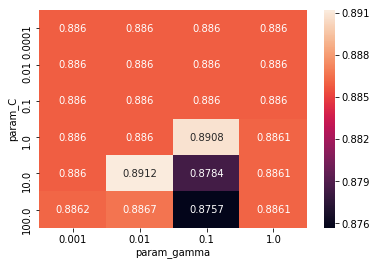

In [27]:
max_scores = df_gridsearch.groupby(['param_C', 
                                    'param_gamma']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [42]:
avg_w2v_optimal_c = 10
avg_w2v_optimal_gamma = 0.01

### 2. SGDClassifier

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.65it/s]


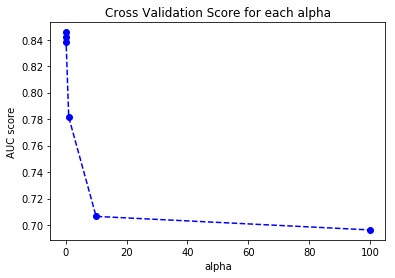

[0.0001, 0.01, 0.1, 1, 10, 100]
[0.8378771470690957, 0.8456105980403805, 0.8417099523358109, 0.7816054780615151, 0.7065775432357161, 0.6963670189224569]


In [95]:
alpha = [0.0001, 0.01, 0.1, 1,10,100]

auc_results=[]
for i in tqdm(alpha):
    
    clf = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    clf.fit(Standardize_X_tr_sent_vectors, y_tr)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(Standardize_X_tr_sent_vectors, y_tr)
    predict_y = sig_clf.predict_proba(Standardize_X_cv_sent_vectors)
    preds = predict_y[:,1]
#     print(predict_y)
    roc_auc = roc_auc_score(y_cv, preds)
    auc_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
plt.plot(alpha, auc_results, 'b--o', label='AUC Score')
plt.title("Cross Validation Score for each alpha")
plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()
print(alpha)
print(auc_results)

In [43]:
avg_w2v_optimal_aplha = 0.01

### Performance measure of Test Data on Trained Model with different performance metrix - AvgWord2Vec
#### 1. SVC RBF Performance

In [44]:
#apply SVC RBF Kernel with optimal c and gamma on test data 
optimal_C = avg_w2v_optimal_c
optimal_gamma = avg_w2v_optimal_gamma
clf = SVC(C = optimal_C,gamma=optimal_gamma,kernel='rbf',class_weight='balanced')
clf.fit(Standardize_X_tr_sent_vectors, y_tr) 
# predict the response
pred = clf.predict(Standardize_X_test_sent_vectors)

####SVC RBF KERNEL SCORE####

The weighted f1_score  with C =10.000000 and Gamma = 0.010000  is 82.809150%

The f1_score with C =10.000000 and Gamma = 0.010000  is 87.497952%

The recall_score with C =10.000000 and Gamma = 0.010000  is 80.120030%

The precision_score with C =10.000000 and Gamma = 0.010000  is 96.372496%

The confusion_matrix with C =10.000000 and Gamma = 0.010000 
[[ 634  201]
 [1325 5340]]


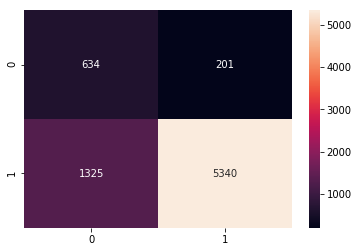

In [45]:
# evaluate weighted f1_score
print("####SVC RBF KERNEL SCORE####")
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score  with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix with C =%f and Gamma = %f ' % (optimal_C,optimal_gamma))
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [46]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix for C = %f and Gamma = %f " %(optimal_C,optimal_gamma))

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for AvgWord2Vec *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix for C = 10.000000 and Gamma = 0.010000 

******* for AvgWord2Vec *********

****TPR is 80%

****FPR is 24%

****FNR is 19%

****TNR is 75%


### 2. SGDClassifier Performance


In [77]:
clf = linear_model.SGDClassifier(alpha=avg_w2v_optimal_aplha,class_weight='balanced')
clf = clf.fit(Standardize_X_tr_sent_vectors, y_tr)
pred = clf.predict(Standardize_X_test_sent_vectors)

#### SGDClassifier SCORE  with alpha =0.010000####

The weighted f1_score is 81.197913%

The f1_score  is 86.052675%

The recall_score is 77.944486%

The precision_score  is 96.043631%

The confusion_matrix 
[[ 621  214]
 [1470 5195]]


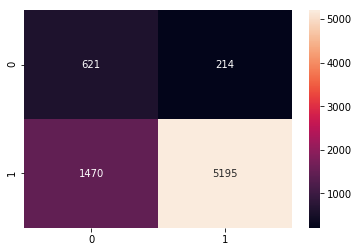

In [78]:
# evaluate weighted f1_score
print("#### SGDClassifier SCORE  with alpha =%f####"% (avg_w2v_optimal_aplha))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score  is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score  is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix ')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [79]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix")

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for AvgWord2Vec *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix

******* for AvgWord2Vec *********

****TPR is 77%

****FPR is 25%

****FNR is 22%

****TNR is 74%


********* Avg_word2vec Ends ***************

## TF-IDF weighted Word2Vec

In [50]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [51]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_tr_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_tr_list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_tr_tfidf_sent_vectors.append(sent_vec)
    row += 1

print(len(X_tr_tfidf_sent_vectors))
print(len(X_tr_tfidf_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 12250/12250 [00:31<00:00, 389.74it/s]


12250
50


In [52]:
#--new way TF-IDF weighted Word2Vec for cv with train data 
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_cv_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_cv_list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_cv_tfidf_sent_vectors.append(sent_vec)
    row += 1

#--------------------------------------------------new way
print(len(X_cv_tfidf_sent_vectors))
print(len(X_cv_tfidf_sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5250/5250 [00:22<00:00, 238.61it/s]


5250
50


In [53]:
#--new way TF-IDF weighted Word2Vec for cv with train data 
   # TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test_list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_sent_vectors.append(sent_vec)
    row += 1

#--------------------------------------------------new way
print(len(X_test_tfidf_sent_vectors))
print(len(X_test_tfidf_sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:26<00:00, 278.43it/s]


7500
50


### col-std on TF-IDF weighted w2vec

In [54]:
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(X_tr_tfidf_sent_vectors)
# print(scaler.fit(X_tr_tfidf_sent_vectors))
# print(scaler.mean_)
Standardize_X_tr_tfidf_sent_vectors= scaler.transform(X_tr_tfidf_sent_vectors)
# print(Standardize_X_tr_tfidf_sent_vectors)
# print(scaler.mean_)
Standardize_X_cv_tfidf_sent_vectors= scaler.transform(X_cv_tfidf_sent_vectors)
# print(Standardize_X_cv_tfidf_sent_vectors)
# print(scaler.mean_)
Standardize_X_test_tfidf_sent_vectors= scaler.transform(X_test_tfidf_sent_vectors)
# print(Standardize_X_test_tfidf_sent_vectors)
# print(scaler.mean_)


### Apply GridSearch on TF-IDF weighted w2vec 

#### 1. SVC RBF KERNEL

In [33]:
Cs = [0.0001, 0.01, 0.1, 1,10,100,100]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=3)
grid_search.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr)

print(grid_search.best_estimator_)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [34]:
# grid_search.grid_scores_, grid_search.best_params_, grid_search.best_score_
df_gridsearch = pd.DataFrame(grid_search.cv_results_)
# df_gridsearch.head()
grid_search.best_params_,grid_search.best_score_

({'C': 10, 'gamma': 0.01}, 0.8893877551020408)

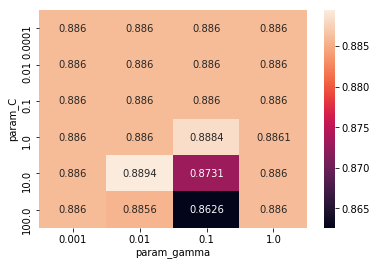

In [35]:
max_scores = df_gridsearch.groupby(['param_C', 
                                    'param_gamma']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [55]:
tfidf_avg_weighted_optimal_c = 10
tfidf_avg_weighte_optimal_gamma = 0.01

### 2. SGDClassifier

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.90it/s]


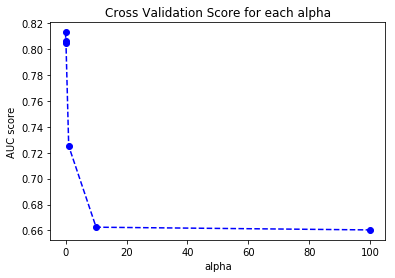

[0.0001, 0.01, 0.1, 1, 10, 100]
[0.8129768348236095, 0.80653630055683, 0.8048058309753696, 0.7251647463754721, 0.6624887964567909, 0.6603871786597673]


In [110]:
alpha = [0.0001, 0.01, 0.1, 1,10,100]

auc_results=[]
for i in tqdm(alpha):
    
    clf = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr)
    predict_y = sig_clf.predict_proba(Standardize_X_cv_tfidf_sent_vectors)
    preds = predict_y[:,1]
#     print(predict_y)
    roc_auc = roc_auc_score(y_cv, preds)
    auc_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
plt.plot(alpha, auc_results, 'b--o', label='AUC Score')
plt.title("Cross Validation Score for each alpha")
plt.ylabel('AUC score')
plt.xlabel('alpha')
plt.show()
print(alpha)
print(auc_results)

In [56]:
tfidf_weighted_w2v_optimal_alpha = 0.0001

### Performance measure of Test Data on Trained Model with different performance metrix- TF-IDF weightedw2vec

#### 1. SVC RBF Kernel Performance

In [57]:
#apply SVC RBF Kernel with optimal c and gamma on test data 
optimal_C = tfidf_avg_weighted_optimal_c
optimal_gamma = tfidf_avg_weighte_optimal_gamma
clf = SVC(C = optimal_C,gamma=optimal_gamma,kernel='rbf',class_weight='balanced')
clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr) 
# predict the response
pred = clf.predict(Standardize_X_test_tfidf_sent_vectors)

####SVC RBF KERNEL SCORE####

The weighted f1_score  with C =10.000000 and Gamma = 0.010000  is 81.439655%

The f1_score with C =10.000000 and Gamma = 0.010000  is 86.257963%

The recall_score with C =10.000000 and Gamma = 0.010000  is 78.214554%

The precision_score with C =10.000000 and Gamma = 0.010000  is 96.145334%

The confusion_matrix with C =10.000000 and Gamma = 0.010000 
[[ 626  209]
 [1452 5213]]


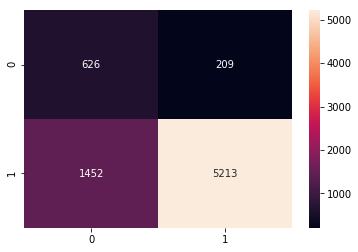

In [58]:
# evaluate weighted f1_score
print("####SVC RBF KERNEL SCORE####")
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score  with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score with C =%f and Gamma = %f  is %f%%' % (optimal_C,optimal_gamma,pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix with C =%f and Gamma = %f ' % (optimal_C,optimal_gamma))
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [59]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix for C = %f and Gamma = %f " %(optimal_C,optimal_gamma))

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for TF-IDF WEIGHTED W2V *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix for C = 10.000000 and Gamma = 0.010000 

******* for TF-IDF WEIGHTED W2V *********

****TPR is 78%

****FPR is 25%

****FNR is 21%

****TNR is 74%


### 2. SGDClassifier Performance


In [65]:
clf = linear_model.SGDClassifier(alpha=tfidf_weighted_w2v_optimal_alpha,class_weight='balanced')
clf = clf.fit(Standardize_X_tr_tfidf_sent_vectors, y_tr)
pred = clf.predict(Standardize_X_test_tfidf_sent_vectors)

#### SGDClassifier SCORE  with alpha =0.000100####

The weighted f1_score is 83.294380%

The f1_score  is 88.657830%

The recall_score is 83.795949%

The precision_score  is 94.118638%

The confusion_matrix 
[[ 486  349]
 [1080 5585]]


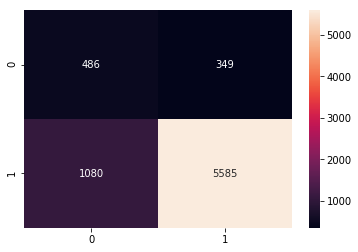

In [66]:
# evaluate weighted f1_score
print("#### SGDClassifier SCORE  with alpha =%f####"% (tfidf_weighted_w2v_optimal_alpha))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score  is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score  is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix ')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [67]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 
print("\n Test confusion_matrix")

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n******* for TF-IDF WIIGHTED W2V *********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))


 Test confusion_matrix

******* for TF-IDF WIIGHTED W2V *********

****TPR is 83%

****FPR is 41%

****FNR is 16%

****TNR is 58%


****** TF-IDF WEIGHTED W2VEC ENDS **

## Conclusion

In [101]:
from prettytable import PrettyTable
print('SVC RBF Performance Table')
x = PrettyTable()
x.field_names =["Vectorizer","Model" ,"GridsearchCV","Train SC", "WeightedF1","F1","Recall","precision","TPR","FPR","FNR","TNR"]

x.add_row(["BOW","RBF","C = 1,γ = 0.001",89.61,85.35,94.33,99.63,89.58,99,92,0,7])
x.add_row(["TF-IDF","RBF","C=1,γ=0.001",88.25,83.78,94.13,99.98,88.92,99,99,0,0])
x.add_row(["AVG W2V","RBF","C = 10,γ= 0.01",89.11,82.80,87.47,80.12,96.37,80,24,19,75])
x.add_row(["TF-IDF W2v","RBF","C = 10,γ= 0.01",88.93,81.43,86.75,78.21,96.14,78,25,21,74])
print(x)

print("\nSGDClassifier Performance Table ")
y = PrettyTable()
y.field_names =["Vectorizer","Model" ,"GridsearchCV","Train SC", "WeightedF1","F1","Recall","precision","TPR","FPR","FNR","TNR"]
y.add_row(["BOW","SGD","alpha =10 ",89,87.63,91.75,87.23,96.64,87,24,12,75])
y.add_row(["TF-IDF","SGD","alpha =10",89.52,86.89,90.99,85.83,96.76,85,23,14,76])
y.add_row(["AVG W2V","SGD","alpha =0.01 ",84.56,81.73,86.05,77.94,96.04,77,25,22,74])
y.add_row(["TF-IDF W2v","SGD","alpha =0.001 ",81,83.21,88.65,83.79,94.11,83,41,16,56])
print(y)

SVC RBF Performance Table
+------------+-------+-----------------+----------+------------+-------+--------+-----------+-----+-----+-----+-----+
| Vectorizer | Model |   GridsearchCV  | Train SC | WeightedF1 |   F1  | Recall | precision | TPR | FPR | FNR | TNR |
+------------+-------+-----------------+----------+------------+-------+--------+-----------+-----+-----+-----+-----+
|    BOW     |  RBF  | C = 1,γ = 0.001 |  89.61   |   85.35    | 94.33 | 99.63  |   89.58   |  99 |  92 |  0  |  7  |
|   TF-IDF   |  RBF  |   C=1,γ=0.001   |  88.25   |   83.78    | 94.13 | 99.98  |   88.92   |  99 |  99 |  0  |  0  |
|  AVG W2V   |  RBF  |  C = 10,γ= 0.01 |  89.11   |    82.8    | 87.47 | 80.12  |   96.37   |  80 |  24 |  19 |  75 |
| TF-IDF W2v |  RBF  |  C = 10,γ= 0.01 |  88.93   |   81.43    | 86.75 | 78.21  |   96.14   |  78 |  25 |  21 |  74 |
+------------+-------+-----------------+----------+------------+-------+--------+-----------+-----+-----+-----+-----+

SGDClassifier Performance Tab